This tutorial is about
- Define Heisenberg Hamiltonian
- Define CNN neural quantum state
- Symmetrize wave functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import quantax as qtx

# 4x4 square lattice, 8 spin-up, 8 spin-down
lattice = qtx.sites.Square(4, Nparticle=(8, 8))
N = lattice.N

In [2]:
from quantax.symmetry import SpinInverse, C4v, Trans2D

# Heisenberg model with Marshall sign rule, default to nearest neighbor
# The lattice is implicitly passed as a global constant
H = qtx.operator.Heisenberg(msr=True)

# residual convolutional network with a summation for the final output
# 2 blocks, 8 channels and 4x4 kernels
net = qtx.model.ResSum(2, 8, 4)

state = qtx.state.Variational(
    net,
    max_parallel=32768,  # maximum forward batch on each machine
)

# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter('error')

sampler = qtx.sampler.SpinExchange(state, 1000)
optimizer = qtx.optimizer.SR(state, H)

In [3]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state.update(step * 1e-3)
    energy_data.append(optimizer.energy)
    VarE_data.append(optimizer.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

KeyboardInterrupt: 

Symmetrized NQS can provide much better performance

$\psi_\mathrm{symm}(s) = \frac{1}{|G|} \sum_g \omega_g^{-1} \psi(T_g s)$

for a symmetry group $\{g\}$ of order $|G|$ represented by operators $T_g$ with
characters $\omega_g$

In [ ]:
# symmetrize the trained NQS

# no need to include translational symmetry, because it's encoded in CNN architecture
symm = SpinInverse() + C4v()

# Symmetrization method 1
symm_state = qtx.state.Variational(
    state.model,  # the trained network
    symm=symm,  # specify symmetry
    max_parallel=32768,
)

# Symmetrization method 2
state.save("/tmp/Heisenberg_params.eqx")  # save as an equinox weight file
net = qtx.model.ResSum(2, 8, 4)  # the same network
symm_state = qtx.state.Variational(
    net,
    param_file="/tmp/Heisenberg_params.eqx",  # load weights
    symm=symm,  # specify symmetry
    max_parallel=32768,
)

sampler = qtx.sampler.SpinExchange(symm_state, 1000)
optimizer = qtx.optimizer.SR(symm_state, H)

2025-08-08 14:34:50.153165: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 14:34:50.325388: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 14:34:50.645829: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 14:34:50.863371: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-08 14:34:51.084543: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86

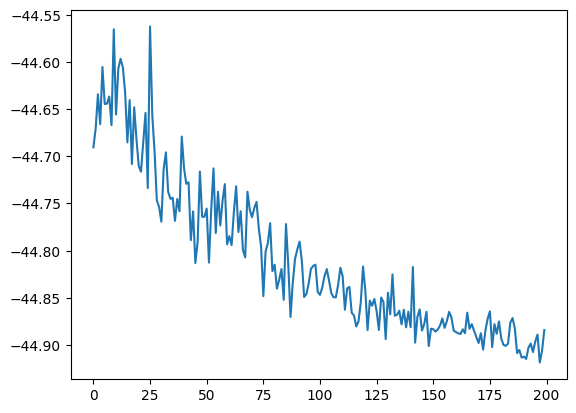

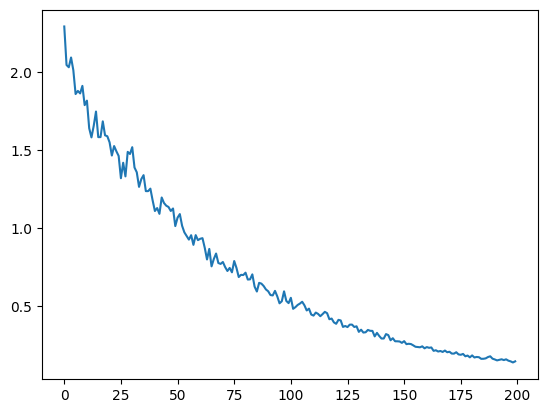

In [ ]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    symm_state.update(step * 1e-3)
    energy_data.append(optimizer.energy)
    VarE_data.append(optimizer.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [6]:
# check result by ED
full_symm = symm + Trans2D()
E, wf = H.diagonalize(full_symm)
print(E[0])

# `GeneralBasisWarning` is because C4v and Trans2D don't commute with each other 

/home/aochen/quantax_env/lib/python3.12/site-packages/quantax/symmetry/symmetry.py:268: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  basis = spin_basis_general(self.N, Nup, pauli=0, make_basis=False, **blocks)


-44.91393283371544
